## Install MediaPipe

In [1]:
%%capture
!pip3 install mediapipe

### Mount Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## use to unzip the file
#!unzip -u "/content/drive/MyDrive/1colab/ML1/AFLW2000-3D.zip" -d "/content/drive/MyDrive/1colab/ML1/New_folder"

In [4]:
# File Paths
file_path="/content/drive/MyDrive/1colab/ML1/New_folder/AFLW2000/"
Test_file_path=file_path+"/Test/"

### Libraries

In [5]:
import numpy as np
import math,random
import cv2
import scipy
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import scipy.io

In [6]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor


### Collect the data and The Labels of Images

In [7]:
def files_name(file_path):
  files=[]
  imgs=[]
  for folder in os.listdir(file_path):
    if folder[-3:]=="mat":
      files.append(folder)
    elif folder[-3:]=="jpg":
      imgs.append(folder)
  return files,imgs



def get_the_labels_dataframe(file_path,files):
  labels=[]
  for mat_file in files:
    mat=scipy.io.loadmat(file_path+mat_file)
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params =list(pre_pose_params[:3])
    pose_params.append(mat_file[5:-4])
    labels.append(pose_params)
  label=pd.DataFrame(labels,columns=["x","y","z","image"])
  return label


In [8]:
mat_files,imgs=files_name(file_path)
print(mat_files[0])
print("the number of mat_files= ",len(mat_files))
print()
print(imgs[0])
print("the number of imgs= ",len(imgs))

image03086.mat
the number of mat_files=  1989

image03238.jpg
the number of imgs=  1989


In [9]:
labels_df=get_the_labels_dataframe(file_path,mat_files)
labels_df.head()

,x,y,z,image
0,-0.671349,-0.972809,0.576308,03086
1,0.510970,-0.974573,-0.369454,03196
2,-0.173138,-0.967009,0.037502,03354
3,0.343784,-0.258636,-0.074890,03350
4,0.106887,0.921113,0.128691,03356


### Using The Mediapipe Face Detection

In [10]:
def detect_face_and_draw_rectangle(file_path,imgs_name):
  imgs=[]
  if isinstance(imgs_name, list):
    imgs=imgs_name
  else:
    imgs.append(imgs_name)

    
  mp_face_detection = mp.solutions.face_detection
  face_detector =  mp_face_detection.FaceDetection( min_detection_confidence = 0.6)

  for img_file in imgs:
    img=cv2.imread(file_path+img_file)
    result=face_detector.process(img)
    img_width=img.shape[1]
    img_height=img.shape[0]
    if result.detections:
      for face in result.detections:
        #print(face)
        bounding_box = face.location_data.relative_bounding_box
        x_min=bounding_box.xmin
        width=bounding_box.width
        y_min=bounding_box.ymin
        height=bounding_box.height

        x=int(x_min*img_width)
        w=int(width*img_width)
        y=int(y_min*img_height)
        h=int(height*img_height)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),thickness=2)
    cv2_imshow(img)


Using Face Detection in Media pipe 

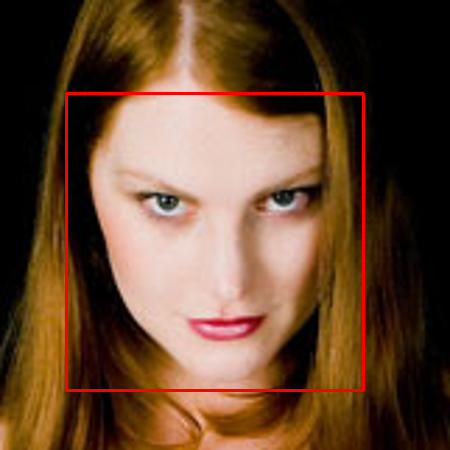

In [11]:
detect_face_and_draw_rectangle(file_path,imgs[0])

### detect landmarks and draw the landmarks

In [12]:
def draw_landmarks(file_path,imgs_name,static_mode):
  imgs=[]
  if isinstance(imgs_name, list):
    imgs=imgs_name
  else:
    imgs.append(imgs_name)

  mp_face_mesh=mp.solutions.face_mesh
  face_mesh=mp_face_mesh.FaceMesh(static_image_mode=static_mode,max_num_faces=1,min_detection_confidence=0.5)
 
  for img_file in imgs:
  
    img=cv2.imread(file_path+img_file)
    results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks !=None:

      landmarks=results.multi_face_landmarks[0]
      for landmark in landmarks.landmark:
          x = landmark.x
          y = landmark.y

          relative_x = int(img.shape[1] * x)
          relative_y = int(img.shape[0] * y)

          #cv2.putText(img, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 1)
          cv2.circle(img, (relative_x, relative_y), 1, (0, 0, 0), -1)
        
      cv2_imshow(img)
    else:
      print("The Image Is Bad and mediapipe facemesh can not detect its landmarks...Image Name: ",img_file)


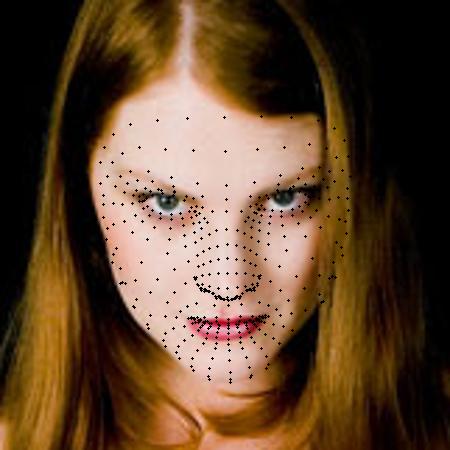

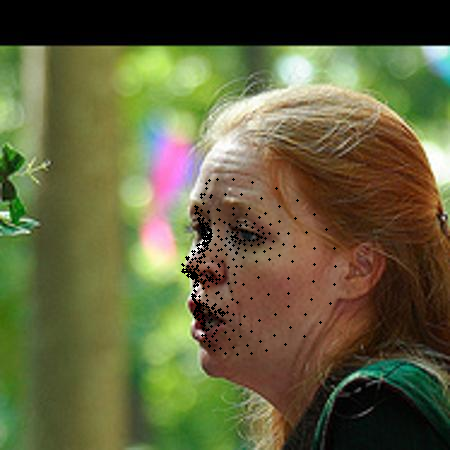

In [13]:
draw_landmarks(file_path,imgs[:2],True)

### get the Features(Landmarks) dataframe

In [14]:

def get_features_landmarks_from_faces_dataframe(file_path,imgs_name):
  mp_face_mesh=mp.solutions.face_mesh
  face_mesh=mp_face_mesh.FaceMesh(static_image_mode=True,max_num_faces=1)
  
  imgs=[]
  if isinstance(imgs_name, list):
    imgs=imgs_name
  else:
    imgs.append(imgs_name)

  bad_img=0
  data=[]
  for img_file in imgs:
    img=cv2.imread(file_path+img_file)
    results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks !=None:
      features=[]
      landmarks=results.multi_face_landmarks[0]
      for landmark in landmarks.landmark:
          x = landmark.x
          y = landmark.y
          features.append(x)
          features.append(y)
            # relative_x = int(img.shape[1] * x)
            # relative_y = int(img.shape[0] * y)
            # features.append(relative_x)
            # features.append(relative_y)

      features.append(img_file[5:-4])
      data.append(features)
    else:
      bad_img +=1
      
  print("The Number of  Bad Imgs That Has No Landmarks: ",bad_img)
  print("The Number of Data :",len(data))
  df=pd.DataFrame(data)
  df.rename(columns={936:"image"},inplace=True)
  return df

In [15]:
features_df=get_features_landmarks_from_faces_dataframe(file_path,imgs)
features_df.head()

The Number of  Bad Imgs That Has No Landmarks:  146
The Number of Data : 1843


,0,1,2,3,4,5,6,7,8,9,...,927,928,929,930,931,932,933,934,935,image
0,0.506972,0.709142,0.506463,0.662146,0.506921,0.667113,0.485436,0.576513,0.506197,0.642201,...,0.471195,0.552493,0.482388,0.545669,0.493138,0.685381,0.435863,0.695092,0.427610,03238
1,0.432006,0.657437,0.409526,0.605061,0.440970,0.625958,0.427965,0.559206,0.408160,0.589644,...,0.526473,0.503291,0.529931,0.492530,0.532311,0.575202,0.524859,0.586545,0.518969,03356
2,0.549331,0.646933,0.583922,0.605034,0.547914,0.619370,0.559119,0.559862,0.587513,0.590875,...,0.508035,0.534383,0.514212,0.539840,0.519147,0.552253,0.497272,0.552978,0.491338,03249
3,0.506107,0.686738,0.507294,0.626504,0.504791,0.640441,0.487110,0.548977,0.507517,0.605090,...,0.473823,0.541361,0.481672,0.536052,0.488371,0.650235,0.456836,0.658069,0.449196,03217
4,0.871238,0.681944,0.862203,0.632509,0.864716,0.642732,0.838590,0.567495,0.859464,0.614658,...,0.491033,0.881710,0.500024,0.877193,0.507266,0.969444,0.465079,0.975643,0.458200,03216


## collect X and Y For The data

In [16]:
def merge_and_find_labels_for_data(data,labels):
  
  df_label=data.merge(labels,how="inner",on="image")
  df_label.set_index("image",inplace=True)
  
  x=df_label.copy()
  x.drop(columns=["x","y","z"],inplace=True)
  
  y=df_label[["x","y","z"]]
  return x,y

In [17]:
x_data,y_data= merge_and_find_labels_for_data(features_df,labels_df)

In [18]:
x_data.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
image,,,,,,,,,,,,,,,,,,,,,
03238,0.506972,0.709142,0.506463,0.662146,0.506921,0.667113,0.485436,0.576513,0.506197,0.642201,...,0.565140,0.471195,0.552493,0.482388,0.545669,0.493138,0.685381,0.435863,0.695092,0.427610
03356,0.432006,0.657437,0.409526,0.605061,0.440970,0.625958,0.427965,0.559206,0.408160,0.589644,...,0.514036,0.526473,0.503291,0.529931,0.492530,0.532311,0.575202,0.524859,0.586545,0.518969
03249,0.549331,0.646933,0.583922,0.605034,0.547914,0.619370,0.559119,0.559862,0.587513,0.590875,...,0.534106,0.508035,0.534383,0.514212,0.539840,0.519147,0.552253,0.497272,0.552978,0.491338
03217,0.506107,0.686738,0.507294,0.626504,0.504791,0.640441,0.487110,0.548977,0.507517,0.605090,...,0.552283,0.473823,0.541361,0.481672,0.536052,0.488371,0.650235,0.456836,0.658069,0.449196
03216,0.871238,0.681944,0.862203,0.632509,0.864716,0.642732,0.838590,0.567495,0.859464,0.614658,...,0.890643,0.491033,0.881710,0.500024,0.877193,0.507266,0.969444,0.465079,0.975643,0.458200


In [19]:
y_data.head()

,x,y,z
image,,,
03238,-0.474087,-0.040907,0.019801
03356,0.106887,0.921113,0.128691
03249,-0.379067,-0.985426,0.086955
03217,-0.192543,0.039903,-0.027199
03216,-0.254934,-0.610480,0.343419


# Split The Data To Train and Test 

In [20]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.33,random_state=42)

# Train The Linear SVR Model

In [21]:
# define base model
model = LinearSVR()
LSVR = MultiOutputRegressor(model)
LSVR.fit(x_train,y_train)
print("score: ",LSVR.score(x_train,y_train))
y_pred=LSVR.predict(x_test)
print("R2: ",r2_score(y_test, y_pred))
print("MSE: ",mean_squared_error(y_test, y_pred))

score:  0.427580225087728
R2:  0.3793267405512654
MSE:  0.29473582402967213


# Train SVR Model

In [22]:
from sklearn.svm import SVR
# define base model
model = SVR()
SVR = MultiOutputRegressor(model)
SVR.fit(x_train,y_train)
print("score: ",SVR.score(x_train,y_train))
y_pred=SVR.predict(x_test)
print("R2: ",r2_score(y_test, y_pred))
print("MSE: ",mean_squared_error(y_test, y_pred))

score:  0.5374081225531877
R2:  0.33698028043178335
MSE:  0.3078922616046081


# Train RandomForestRegressor Model

In [23]:

RF= MultiOutputRegressor(RandomForestRegressor(n_estimators=2,max_depth=5))
RF.fit(x_train, y_train)
print("score: ",RF.score(x_train,y_train))
y_pred=RF.predict(x_test)

print("R2: ",r2_score(y_test, y_pred))
print("MSE: ",mean_squared_error(y_test, y_pred))

score:  0.5158764865190619
R2:  0.46401051814574784
MSE:  0.2169313341261059


# Train DecisionTreeRegressor Model

In [24]:
DT = MultiOutputRegressor(DecisionTreeRegressor(max_depth=5,min_samples_split=0.001,min_samples_leaf=0.001))
DT.fit(x_train, y_train)
print("score: ",DT.score(x_train,y_train))
y_pred=DT.predict(x_test)
print("R2: ",r2_score(y_test, y_pred))
print("MSE: ",mean_squared_error(y_test, y_pred))

score:  0.7355904689324158
R2:  0.43487448955747254
MSE:  0.24183251751164145


#### Test _Images

In [25]:
Test_mat,Test_imgs=files_name(Test_file_path)
print(Test_mat[0])
print("the number of mat_files= ",len(Test_mat))
print()
print(Test_imgs[0])
print("the number of imgs= ",len(Test_imgs))

image00014.mat
the number of mat_files=  11

image00019.jpg
the number of imgs=  11


In [26]:
Test_labels_df=get_the_labels_dataframe(Test_file_path,Test_mat)
Test_labels_df.head()

,x,y,z,image
0,0.057119,0.110732,-0.043283,00014
1,0.236453,1.250053,0.167051,00022
2,-0.184650,0.881137,-0.236852,00006
3,-0.175379,0.299208,-0.373374,00008
4,-0.170780,0.383899,-0.436852,00020


In [27]:
Test_features_df=get_features_landmarks_from_faces_dataframe(Test_file_path,Test_imgs)
Test_features_df.head()

The Number of  Bad Imgs That Has No Landmarks:  1
The Number of Data : 10


,0,1,2,3,4,5,6,7,8,9,...,927,928,929,930,931,932,933,934,935,image
0,0.504923,0.660781,0.504300,0.590029,0.504618,0.615602,0.489647,0.534049,0.504232,0.570568,...,0.502882,0.537676,0.505533,0.532564,0.506306,0.629079,0.496832,0.638516,0.492394,00019
1,0.500070,0.677207,0.463701,0.625045,0.484325,0.635931,0.437842,0.569959,0.455318,0.608590,...,0.494878,0.483354,0.503987,0.476720,0.510525,0.564460,0.454512,0.572303,0.445920,00020
2,0.510238,0.669038,0.492729,0.604797,0.499756,0.624468,0.467368,0.542362,0.488200,0.584701,...,0.481912,0.510743,0.488652,0.505667,0.492681,0.602484,0.452699,0.611310,0.448576,00013
3,0.432730,0.639559,0.409750,0.582831,0.440336,0.603227,0.428533,0.534794,0.408958,0.566832,...,0.496137,0.501945,0.500745,0.491224,0.503503,0.573364,0.485283,0.583688,0.479568,00022
4,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,0.745973,0.321459,0.767816,...,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798,00006


In [28]:
Test_x,Test_y=merge_and_find_labels_for_data(Test_features_df,Test_labels_df)

### Draw Axis for Direction

In [29]:
from math import cos,sin
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [30]:
def Test_images(model,x,y):

  f, axarr = plt.subplots(10,2,figsize=(30,50)) 
  for j in range(len(y)):
    #print()
    idx=list(y.iloc[[j]].index)[0]
    #print(idx)
    pred=model.predict(x.iloc[[j]])
    p_pred,y_pred,r_pred=pred[0][0],pred[0][1],pred[0][2]
  # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    image=cv2.imread(file_path+"/Test/image"+idx+".jpg")
    image3=cv2.imread(file_path+"/Test/image"+idx+".jpg")
    degree=y.iloc[[j]]
    pitch,yaw,roll=degree["x"],degree["y"],degree["z"]
    #print(pitch,yaw,roll)
    image2=draw_axis(image,pitch,yaw,roll)
    image4=draw_axis(image3,p_pred,y_pred,r_pred)
    axarr[j,0].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    axarr[j,1].imshow(cv2.cvtColor(image4, cv2.COLOR_BGR2RGB))

Test LSVR Model

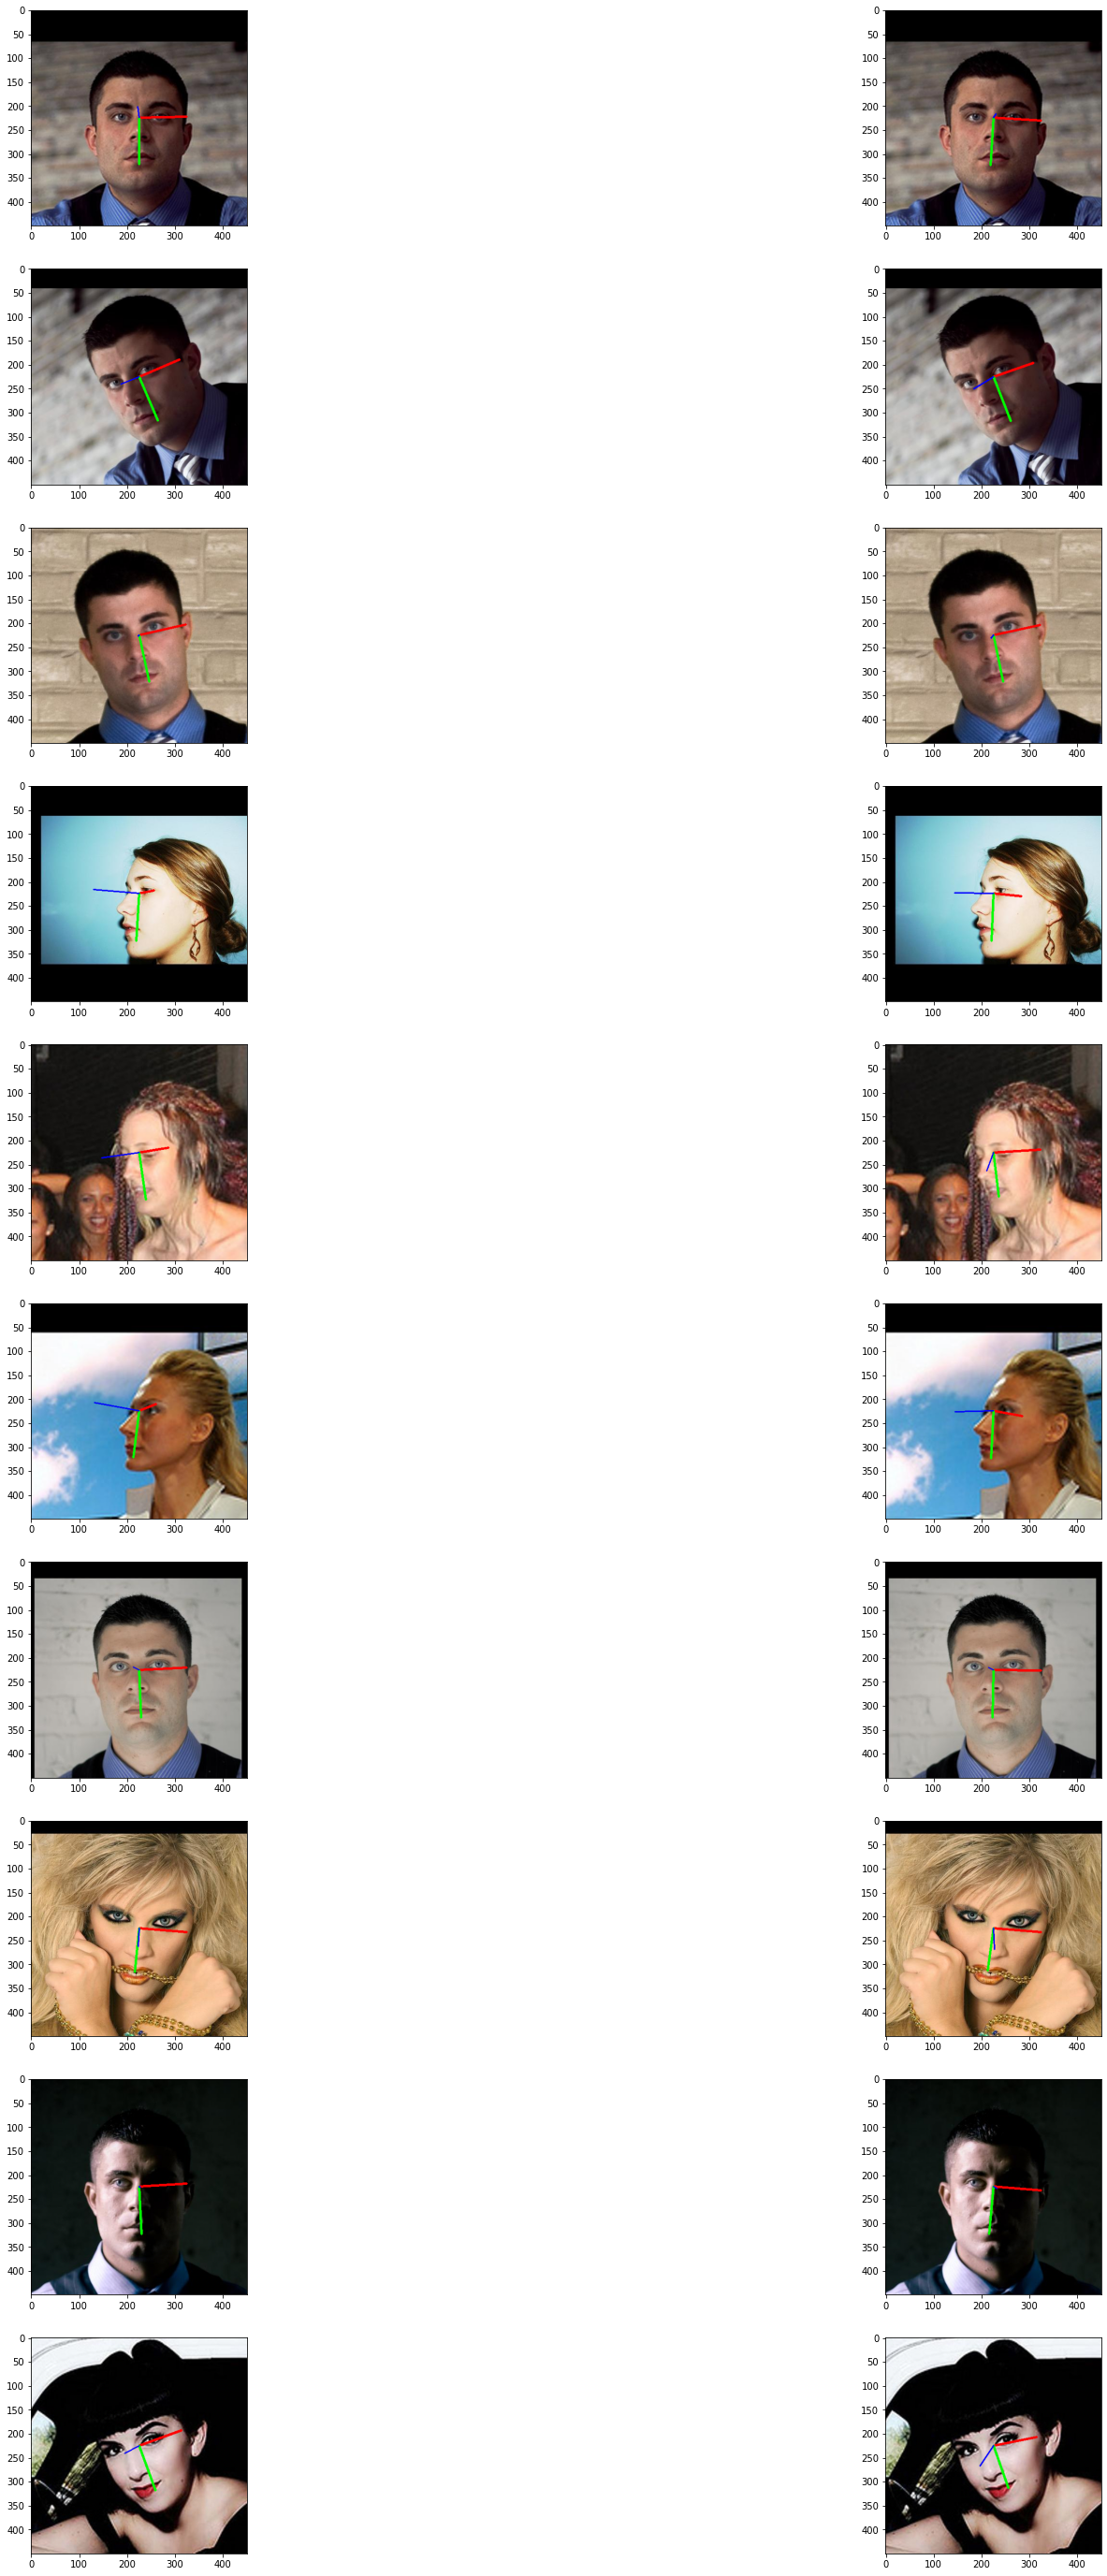

In [31]:
Test_images(LSVR,Test_x,Test_y)

Test On Video 

In [32]:
mp_face_mesh=mp.solutions.face_mesh
face_mesh=mp_face_mesh.FaceMesh(static_image_mode=False,max_num_faces=1,min_detection_confidence=0.5)

In [33]:
v_path="/content/drive/MyDrive/1colab/ML1New_folder/vid2.mp4"

In [34]:

cap=cv2.VideoCapture(v_path)
fourcc=int(cap.get(cv2.CAP_PROP_FOURCC))

FPS=int(cap.get(cv2.CAP_PROP_FPS))

draw = mp.solutions.drawing_utils

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)

result = cv2.VideoWriter("/content/drive/MyDrive/1colab/ML1/LSVR_1.mp4", cv2.VideoWriter_fourcc(*'MP4V'), FPS, size)

success, img = cap.read()
while (cap.isOpened()and success ): 
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(imgRGB)
    
    if results.multi_face_landmarks !=None:
      features=[]

      landmarks=results.multi_face_landmarks[0]
      for landmark in landmarks.landmark:
          x = landmark.x
          y = landmark.y
          features.append(x)
          features.append(y)
          # relative_x = int(img.shape[1] * x)
          # relative_y = int(img.shape[0] * y)
          # features.append(relative_x)
          # features.append(relative_y)
      features=np.array(features).reshape((1,-1))
      
      pred=LSVR.predict(features)
      p_pred,y_pred,r_pred=pred[0][0],pred[0][1],pred[0][2]
      
      
      tdx=features[0][2]*img.shape[1] 
      tdy=features[0][3]*img.shape[0] 
      image4=draw_axis(img,p_pred,y_pred,r_pred,tdx,tdy)
     
      print("OK")

        # draw.draw_landmarks(
        #   img,results.multi_face_landmarks[0])

    #cv2_imshow(img)
    result.write(image4)
    success, img = cap.read()


cap.release()
result.release()
cv2.destroyAllWindows()

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
O